In [1]:
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

In [2]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
print(train_input.shape, val_input.shape, test_input.shape)

(20000,) (5000,) (25000,)


In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [5]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras', save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.5110 - loss: 0.6929 - val_accuracy: 0.5864 - val_loss: 0.6911
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.5784 - loss: 0.6907 - val_accuracy: 0.6258 - val_loss: 0.6874
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.6217 - loss: 0.6858 - val_accuracy: 0.6562 - val_loss: 0.6765
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.6681 - loss: 0.6682 - val_accuracy: 0.7096 - val_loss: 0.6177
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.7180 - loss: 0.6006 - val_accuracy: 0.7248 - val_loss: 0.5760
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.7282 - loss: 0.5690 - val_accuracy: 0.7404 - val_loss: 0.5555
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.7481 - loss: 0.5465 - val_accuracy: 0.7450 - val_loss: 0.5383
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7600 - loss: 0

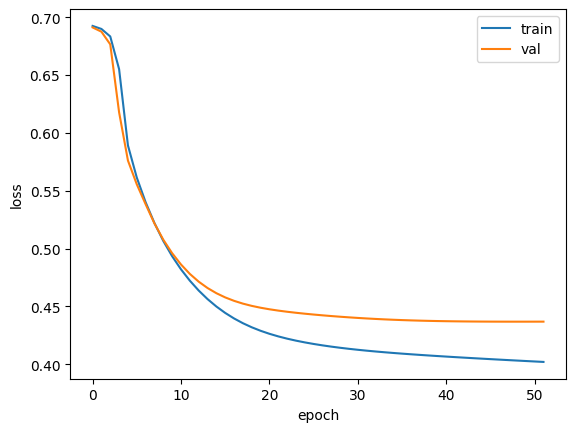

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

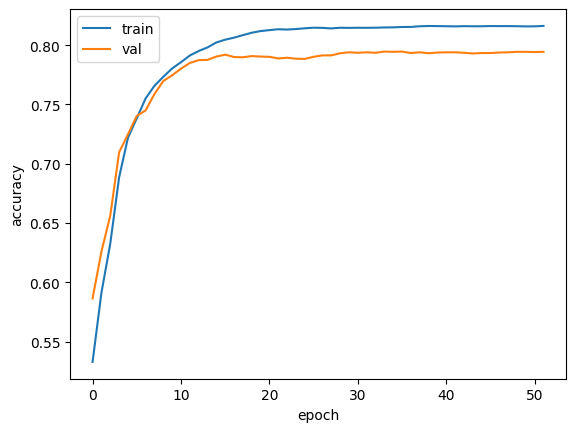

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.show()

In [14]:
# 커스텀LSTM
class CustomLSTM(keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super(CustomLSTM, self).__init__(**kwargs)
    self.units = units
  def build(self, input_shape):
    input_dim = input_shape[-1]

    self.W_i = self.add_weight(name='W_i', shape=(input_dim, self.units), initializer='glorot_uniform')
    self.U_i = self.add_weight(name='U_i', shape=(self.units, self.units), initializer='glorot_uniform')
    self.b_i = self.add_weight(name='b_i', shape=(self.units,), initializer='zeros')

    self.W_f = self.add_weight(name='W_f', shape=(input_dim, self.units), initializer='glorot_uniform')
    self.U_f = self.add_weight(name='U_f', shape=(self.units, self.units), initializer='glorot_uniform')
    self.b_f = self.add_weight(name='b_f', shape=(self.units,), initializer='zeros')

    self.W_o = self.add_weight(name='W_o', shape=(input_dim, self.units), initializer='glorot_uniform')
    self.U_o = self.add_weight(name='U_o', shape=(self.units, self.units), initializer='glorot_uniform')
    self.b_o = self.add_weight(name='b_o', shape=(self.units,), initializer='zeros')

    self.W_g = self.add_weight(name='W_g', shape=(input_dim, self.units), initializer='glorot_uniform')
    self.U_g = self.add_weight(name='U_g', shape=(self.units, self.units), initializer='glorot_uniform')
    self.b_g = self.add_weight(name='b_g', shape=(self.units,), initializer='zeros')

    super(CustomLSTM, self).build(input_shape)

  def call(self, inputs):
    timesteps = tf.shape(inputs)[1]
    batch_size = tf.shape(inputs)[0]

    h_t = tf.zeros((batch_size, self.units))
    c_t = tf.zeros((batch_size, self.units))
    def lstm_step(carry, x_t):
      h_t, c_t = carry
      i_t = tf.sigmoid(tf.matmul(x_t, self.W_i) + tf.matmul(h_t, self.U_i) + self.b_i)
      f_t = tf.sigmoid(tf.matmul(x_t, self.W_f) + tf.matmul(h_t, self.U_f) + self.b_f)
      o_t = tf.sigmoid(tf.matmul(x_t, self.W_o) + tf.matmul(h_t, self.U_o) + self.b_o)
      g_t = tf.tanh(tf.matmul(x_t, self.W_g) + tf.matmul(h_t, self.U_g) + self.b_g)
      # cell 상태 업데이트
      c_t = f_t * c_t + i_t * g_t
      # 은닉 상태 업데이트
      h_t = o_t * tf.tanh(c_t)
      return h_t, c_t
    inputs_t = tf.transpose(inputs, perm=[1, 0, 2])
    _, outputs = tf.scan(lstm_step, inputs_t, initializer=(h_t, c_t), parallel_iterations=1)
    final_h = outputs[-1]
    return final_h

c_model = keras.Sequential()

c_model.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
c_model.add(CustomLSTM(8))
c_model.add(keras.layers.Dense(1, activation='sigmoid'))

c_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_lstm_5 (CustomLSTM)      │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
c_model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-c-lstm-model.keras', save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = c_model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.5130 - loss: 0.6929 - val_accuracy: 0.5520 - val_loss: 0.6919
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.5542 - loss: 0.6915 - val_accuracy: 0.5744 - val_loss: 0.6903
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 93ms/step - accuracy: 0.5811 - loss: 0.6895 - val_accuracy: 0.5880 - val_loss: 0.6879
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.5971 - loss: 0.6864 - val_accuracy: 0.5944 - val_loss: 0.6839
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 91ms/step - accuracy: 0.6106 - loss: 0.6814 - val_accuracy: 0.6112 - val_loss: 0.6775
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - accuracy: 0.6234 - loss: 0.6736 - val_accuracy: 0.6240 - val_loss: 0.6674
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - accuracy: 0.6391 - loss: 0.6613 - val_accuracy: 0.6388 - val_loss: 0.6511
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.6596 - loss: 0

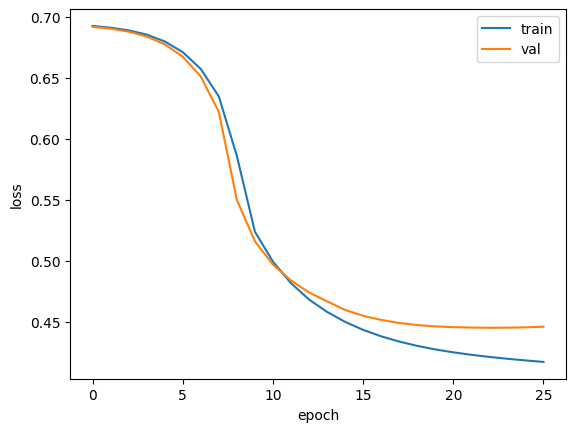

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

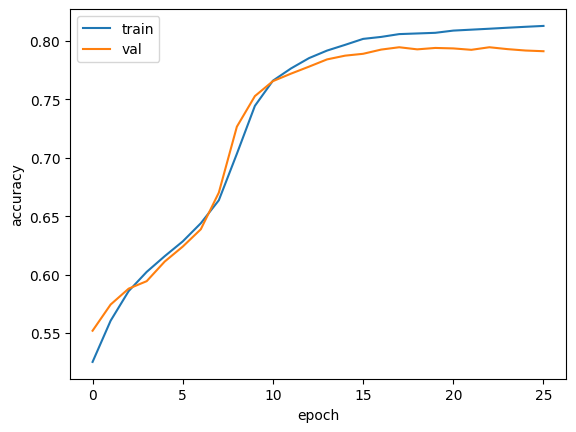

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.show()

In [18]:
bi_model = keras.Sequential()

bi_model.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
bi_model.add(keras.layers.Bidirectional(keras.layers.LSTM(8)))
bi_model.add(keras.layers.Dense(1, activation='sigmoid'))

bi_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 16)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,617 (37.57 KB)

 Trainable params: 9,617 (37.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
bi_model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-bi-lstm-model.keras', save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = bi_model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.5187 - loss: 0.6925 - val_accuracy: 0.5738 - val_loss: 0.6908
Epoch 2/100
 62/313 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.5788 - loss: 0.6911